# __DAT-901 Customer Recommender__
<img src="asset/image/gift.png"
     alt="gift"
     style="float: right; margin-right: 100px; height: 100px" />

_Sana AMMAR, Yannis BOUACEM, Nicolas PICHARD_ 
<br>
<br>
***
<br>


## __1. Data preparation__
 - 1.1. Import modules
 - 1.2. Import data
 
<br>

## __2. Preprocessing__
 
 
<br>

## __3. Exploring data__
 - 3.1. Display various data
 - 3.2. Pivot table client and item (weighted)
 - 3.3. Pivot table client and item
 
<br>

## __4. Processing data__
 - 4.1. Collaborative filtering
 - 4.2. Segmentation
 
  <br>
 

## __1. Data preparation__
_First import all module needed_
<br>

***

<br>

### 1.2. Import modules

In [209]:
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import csv
import os
import datetime
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import (
    Concatenate,
    Dense,
    Embedding,
    Flatten,
    Input,
    Multiply,
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

#preprocessing
from sklearn.preprocessing import OrdinalEncoder

sns.set()

### 1.2. Import data

In [210]:
FILEPATH = os.getcwd()

FILENAME = "KaDo_less.csv"

# Retourne DataFrame
df = pd.read_csv(f"{FILEPATH}/data/{FILENAME}", encoding="utf8")

# Display df dimensions
display(f'Dataframe dimensions: {df.shape}')

'Dataframe dimensions: (10000, 8)'

In [217]:
# Infos types/null valeurs
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
display(tab_info)

,TICKET_ID,MOIS_VENTE,PRIX_NET,FAMILLE,UNIVERS,MAILLE,LIBELLE,CLI_ID
column type,int64,int64,float64,object,object,object,object,int64
null values (nb),0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## __2. Preprocessing__
_Segment data, try to understand and display particular indicator_

***
<br>

In [14]:
def clean_data(df_clean):
    # Drop TICKET_ID
    features = ["MOIS_VENTE", "PRIX_NET", "FAMILLE", "UNIVERS", "MAILLE", "LIBELLE", "CLI_ID"]
    # Création d'un encoder ordinal pour transformer les valeurs des features catégoriques
    ordinal_encoder = OrdinalEncoder()
    cat_cols = ["FAMILLE", "UNIVERS", "MAILLE"]
    df_clean[cat_cols] = ordinal_encoder.fit_transform(df_clean[cat_cols])

    return df_clean[features]

In [219]:
df_train = clean_data(df.copy())
df_train.head()

,MOIS_VENTE,PRIX_NET,FAMILLE,UNIVERS,MAILLE,LIBELLE,CLI_ID
0,10,1.67,1.0,30.0,9.0,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281
1,10,1.66,1.0,30.0,9.0,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281
2,10,7.45,5.0,74.0,30.0,CR JR PARF BIO.SPE AC.SENT.50ML,1490281
3,10,5.95,5.0,78.0,25.0,EAU MICELLAIRE 3 THES FL200ML,1490281
4,10,1.67,1.0,30.0,9.0,GD JDM4 TIARE FL 200ML,1490281


## __3. Exploring data__
_Analyse, understand and display particular indicator_

***

<br>

### 3.1. Display various data

In [216]:
# Prix des items par famille
df_famille_prix = df[["FAMILLE", "PRIX_NET"]].sort_values(by=['FAMILLE', 'PRIX_NET'])
display(df_famille_prix)

,FAMILLE,PRIX_NET
1864,CAPILLAIRES,1.50
397,CAPILLAIRES,2.45
2499,CAPILLAIRES,2.45
3556,CAPILLAIRES,2.45
4041,CAPILLAIRES,2.45
...,...,...
8822,SOLAIRES,18.00
3876,SOLAIRES,18.95
440,SOLAIRES,23.50
6763,SOLAIRES,23.50


<Figure size 2160x720 with 0 Axes>

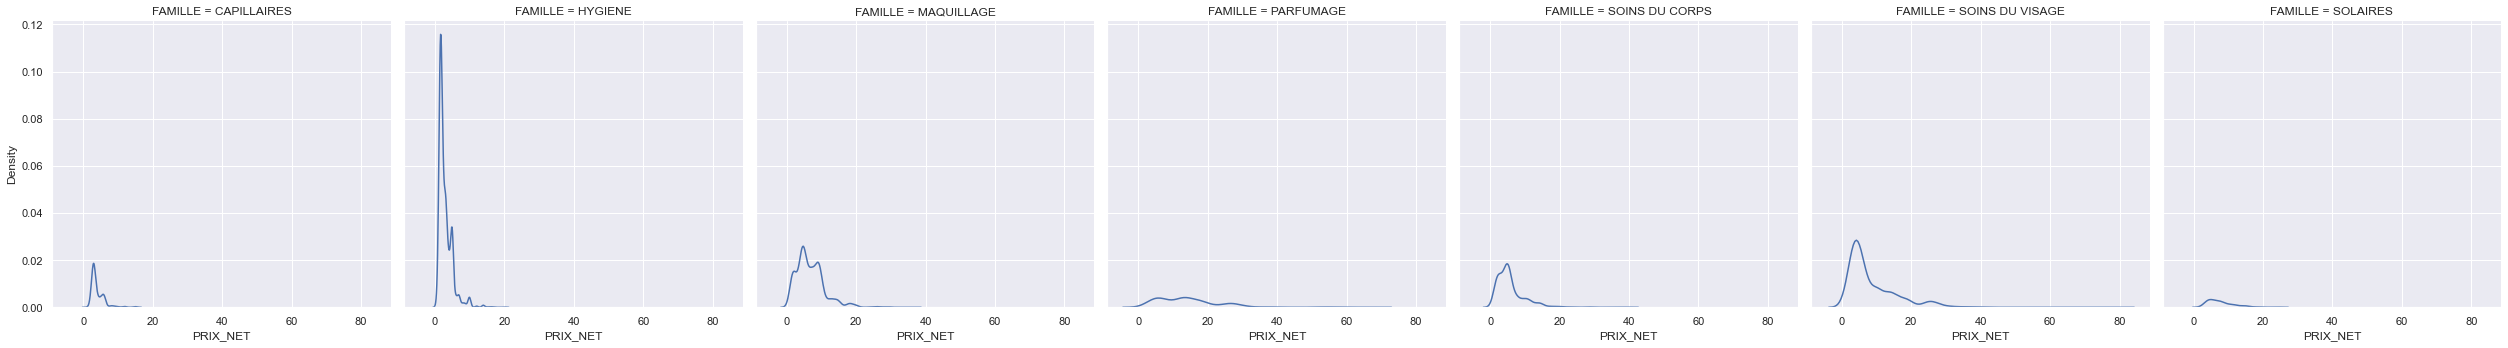

In [214]:
fig = plt.figure(figsize = (30, 10))
sns.displot(
    data = df_famille_prix,
    col = "FAMILLE",
    x = "PRIX_NET",
    kind = "kde",
)

In [215]:
print('Max price:', max(df.PRIX_NET))
print('Min price:', min(df.PRIX_NET))
print('Median price:', df.PRIX_NET.median())
print('Mean price:', df.PRIX_NET.mean())

Max price: 79.5
Min price: 0.65
Median price: 4.9
Mean price: 6.592878000000002


Text(0, 0.5, "Nombre d'achats")

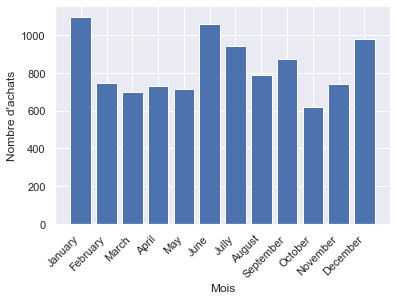

In [35]:
# Quantité d'items achetés par mois
months = ["January", "February", "March", "April", "May", "June", "Jully", "August", "September", "October", "November", "December"]
df_months = df_train["MOIS_VENTE"].value_counts().sort_index()
df_months.index = months

ax = plt.bar(
    df_months.index,
    height = df_months.values
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Mois")
plt.ylabel("Nombre d'achats")

Text(0, 0.5, "Nombre d'achats")

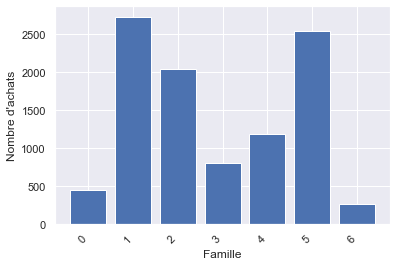

In [36]:
# Quantité d'items achetés par famille
df_familles = df["FAMILLE"].value_counts()

ax = plt.bar(
    df_familles.index,
    height = df_familles.values
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Famille")
plt.ylabel("Nombre d'achats")

Text(0.5, 1.0, 'January')

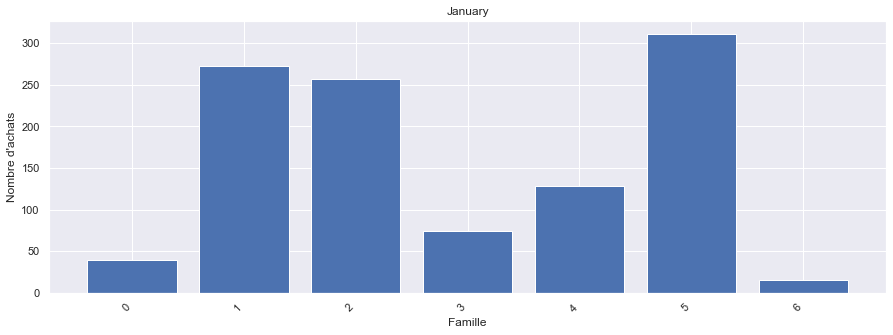

In [37]:
# Quantité d'items achetés par famille pour le mois X

# MONTH (January = 1, February = 2, ...)
month = 1
fig = plt.figure(figsize = (15, 5))
df_month = df.loc[df_train["MOIS_VENTE"] == month]["FAMILLE"].value_counts()

ax = plt.bar(
    df_month.index,
    height = df_month.values
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Famille")
plt.ylabel("Nombre d'achats")
plt.title(months[month - 1])

[Text(0.5, 0, 'Prix moyen par commande (en €)'),
 Text(0, 0.5, 'Nombre de commandes par client')]

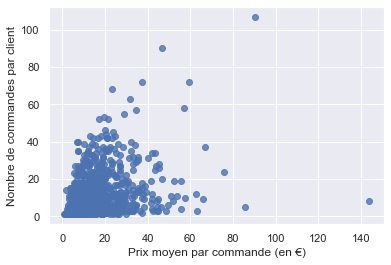

In [40]:
# Nombre de commandes par prix moyen des commandes
df_mean_command = df.groupby(["CLI_ID", "TICKET_ID"], as_index=False)["PRIX_NET"].sum().groupby("CLI_ID")["PRIX_NET"].mean()
df_num_command = df.groupby(["CLI_ID"])["TICKET_ID"].count()
df_command = pd.concat([df_mean_command, df_num_command], axis = 1)
df_command = df_command.rename(columns = {'PRIX_NET': 'MEAN', 'TICKET_ID': 'COUNT'})
ax = sns.regplot(x = df_command["MEAN"], y =  df_command["COUNT"], fit_reg = False)
ax.set(
    xlabel = "Prix moyen par commande (en €)",
    ylabel = "Nombre de commandes par client"
)

[Text(0.5, 0, 'Prix moyen par commande (en €)')]

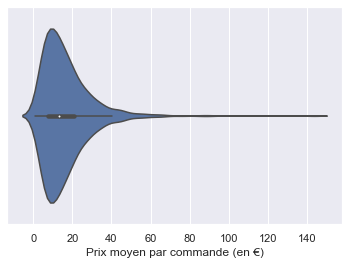

In [42]:
# Répartition des prix des commandes
ax = sns.violinplot(x=df_mean_command)
ax.set(
    xlabel = "Prix moyen par commande (en €)"
)

[Text(0.5, 0, 'Nombre commandes par client')]

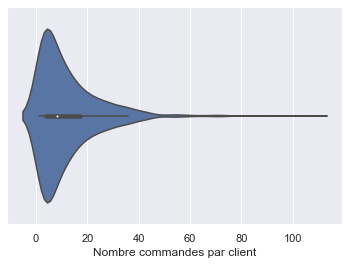

In [41]:
# Répartition du nombre de commandes par client
ax = sns.violinplot(x=df_num_command)
ax.set(
    xlabel = "Nombre commandes par client"
)

In [43]:
# Retourne les commandes depuis un client_id
client_id = 1490281
display(df.loc[df["CLI_ID"] == client_id])

,TICKET_ID,MOIS_VENTE,PRIX_NET,FAMILLE,UNIVERS,MAILLE,LIBELLE,CLI_ID
0,35592159,10,1.67,1.0,30.0,9.0,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281
1,35592159,10,1.66,1.0,30.0,9.0,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281
2,35592159,10,7.45,5.0,74.0,30.0,CR JR PARF BIO.SPE AC.SENT.50ML,1490281
3,35592159,10,5.95,5.0,78.0,25.0,EAU MICELLAIRE 3 THES FL200ML,1490281
4,35592159,10,1.67,1.0,30.0,9.0,GD JDM4 TIARE FL 200ML,1490281


In [44]:
# Retourne la commande depuis un ticket_id
ticket_id = 35592159
display(df.loc[df["TICKET_ID"] == ticket_id])

,TICKET_ID,MOIS_VENTE,PRIX_NET,FAMILLE,UNIVERS,MAILLE,LIBELLE,CLI_ID
0,35592159,10,1.67,1.0,30.0,9.0,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281
1,35592159,10,1.66,1.0,30.0,9.0,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281
2,35592159,10,7.45,5.0,74.0,30.0,CR JR PARF BIO.SPE AC.SENT.50ML,1490281
3,35592159,10,5.95,5.0,78.0,25.0,EAU MICELLAIRE 3 THES FL200ML,1490281
4,35592159,10,1.67,1.0,30.0,9.0,GD JDM4 TIARE FL 200ML,1490281


In [63]:
# Quantités d'items achetés par un client
df_collab = df_train.drop(columns=['MOIS_VENTE', 'PRIX_NET','FAMILLE' ,'UNIVERS' ,'MAILLE'])
qte_libelle = pd.DataFrame(df_collab.value_counts()).reset_index()
qte_libelle.columns = ['LIBELLE', 'CLI_ID', 'COUNT']
display(qte_libelle)

,LIBELLE,CLI_ID,COUNT
0,LTN DERM/AP BIO.SPE.AC.SENS.150ML,901046554,18
1,LINGETTES CALMILLE 2013,902463419,13
2,25 LINGETTES DEFROISSANTES SV,800457695,13
3,SOIN CONC COMP RC2 FL POMP40ML,902381207,13
4,GEL DOUCHE FRAICHEUR 200ML,800273092,12
...,...,...,...
7332,EDT UN MATIN AU JARDIN 100ML LILAS,800006244,1
7333,EDT UN MATIN AU JARDIN 100ML LILAS,760672670,1
7334,EDT UN MATIN AU JARDIN 100ML LILAS,383061124,1
7335,EDT UN MATIN AU JARDIN 100ML LILAS,382969442,1


### 3.2. Pivot table client and item (weighted)
_We count every time a client bought an item and use it as a feedback. We assume that if a client bought an item, it's an implicite feedback and the amount of purchase of this specific item is the feedback given._

In [66]:
# Création de la table pivot (CLI_ID column, LIBELLE row et COUNT values)
pivot_weight_df = qte_libelle.pivot_table(index = 'CLI_ID', columns='LIBELLE', fill_value = 0)
array_weight_pivot = pivot_weight_df.to_numpy()

pivot_weight_df.head()

COUNT                          \
LIBELLE  2013 GD PARFUME F200 ML EVIDENCE 2013-GD 200ML SO ELIXIR   
CLI_ID                                                              
1490281                                 0                       0   
13290776                                0                       0   
20163348                                0                       0   
20200041                                0                       0   
20561854                                0                       0   

                                          \
LIBELLE  2013-LAIT PARF 200 ML SO ELIXIR   
CLI_ID                                     
1490281                                0   
13290776                               0   
20163348                               0   
20200041                               0   
20561854                               0   

                                                  \
LIBELLE  2013COL 10ANS EDP50ML COMMEUNE EVIDENCE   
CLI_ID                                             
1490281                                        0   
13290776                                       0   
20163348                                       0   
20200041                                       0   
20561854                                       0   

                                                   \
LIBELLE  2014 COLLECT EDP 50ML COMME UNE EVIDENCE   
CLI_ID                                              
1490281                                         0   
13290776                                        0   
20163348                                        0   
20200041                                        0   
20561854                                        0   

                                                   \
LIBELLE  2014 COLLECTOR EDP 50ML SO ELIXIR PURPLE   
CLI_ID                                              
1490281                                         0   
13290776                                        0   
20163348                                        0   
20200041                                        0   
20561854                                        0   

                                                                      \
LIBELLE  25 LINGETTES DEFROISSANTES SV 49C ANTI CHUTE CURE STIM 60ML   
CLI_ID                                                                 
1490281                              0                             0   
13290776                             0                             0   
20163348                             0                             0   
20200041                             0                             0   
20561854                             0                             0   

                                                                       ...  \
LIBELLE  AB SVA BRUM EXPR CORP FL150ML AB SVA JAMBES D'ETE  T75 INTER  ...   
CLI_ID                                                                 ...   
1490281                              0                              0  ...   
13290776                             0                              0  ...   
20163348                             0                              0  ...   
20200041                             0                              0  ...   
20561854                             0                              0  ...   

                                                                              \
LIBELLE  VAO VERT GIVRE 62 HIV14 ANI LU4 3ML VAO VIOLET ELECTRIQ 42 LUM4 3ML   
CLI_ID                                                                         
1490281                                    0                               0   
13290776                                   0                               0   
20163348                                   0                               0   
20200041                                   0                               0   
20561854                                   0                               0   

                    

### 3.3. Pivot table client and item 
_We assume that if a client bought an item, it's an implicite feedback. However we don't quantify it (1/0)_

In [95]:
# Change values to 1
qte_libelle["COUNT"].loc[qte_libelle["COUNT"] > 1] = 1

# Création de la table pivot (CLI_ID column, LIBELLE row et COUNT values)
pivot_df = qte_libelle.pivot_table(index = 'CLI_ID', columns='LIBELLE', values = 'COUNT', fill_value = 0)
array_pivot = pivot_df.to_numpy()

pivot_df.head()

LIBELLE,2013 GD PARFUME F200 ML EVIDENCE,2013-GD 200ML SO ELIXIR,2013-LAIT PARF 200 ML SO ELIXIR,2013COL 10ANS EDP50ML COMMEUNE EVIDENCE,2014 COLLECT EDP 50ML COMME UNE EVIDENCE,2014 COLLECTOR EDP 50ML SO ELIXIR PURPLE,25 LINGETTES DEFROISSANTES SV,49C ANTI CHUTE CURE STIM 60ML,AB SVA BRUM EXPR CORP FL150ML,AB SVA JAMBES D'ETE T75 INTER,...,VAO VERT GIVRE 62 HIV14 ANI LU4 3ML,VAO VIOLET ELECTRIQ 42 LUM4 3ML,VAO VIOLINE AUTOMNE14 3ML,VINAIGRE DE RINCAGE FRAMBOISE 150ML,VOILE DE TT CLAIR NAT 01 LU4 30ML,VOILE DE TT MAT/NATUR 03 LU4 30ML,VOILE DE TT MEDIUM NAT 02 LU4 30ML,ZERO TRACE SPRAY SPF 15 FL150,ZERO TRACE SPRAY SPF 30 150ML,x99SS GELEE FRUITS VANIL PN2 10ML
CLI_ID,,,,,,,,,,,,,,,,,,,,,
1490281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13290776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20163348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20200041,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20561854,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# __4. Processing data__
_Use different models to process data and create a recommender system_

***
<br>

### 4.1. Collaborative filtering

In [96]:
# Array de toutes les entrées de la table pivot
def wide_to_long(wide, ratings):
    
    def _get_ratings(arr, rating):
        idx = np.where(arr == rating)
        return np.vstack(
            (idx[0], idx[1], np.ones(idx[0].size, dtype="int8") * rating)
        ).T

    long_arrays = []
    for r in ratings:
        long_arrays.append(_get_ratings(wide, r))

    return np.vstack(long_arrays)

In [97]:
long = wide_to_long(array_pivot, np.unique(array_pivot))
df = pd.DataFrame(long, columns=["CLI_ID", "LIBELLE", "interaction"])

long_weight = wide_to_long(array_weight_pivot, np.unique(array_weight_pivot))
df_weight = pd.DataFrame(long_weight, columns=["CLI_ID", "LIBELLE", "interaction"])

In [99]:
# On tente de réduire le poids des interactions quand celles-ci sont pondérées
df_weight_red = pd.DataFrame(df_weight, columns=["CLI_ID", "LIBELLE", "interaction"])
df_weight_red["interaction"] = np.sqrt(df_weight["interaction"])

### Model

In [100]:
# Define N_EPOCHS as the number of epochs we'll do
N_EPOCHS = 10

In [101]:
# Define the neural collaborative filter
def create_ncf(
    nb_users: int,
    nb_items: int,
    latent_dim_mf: int = 4,
    latent_dim_mlp: int = 32,
    reg_mf: int = 0,
    reg_mlp: int = 0.01,
    
    dense_layers: List[int] = [8, 4],
    reg_layers: List[int] = [0.01, 0.01],
    activation_dense: str = "relu",
) -> keras.Model:

    # input layer
    user = Input(shape=(), dtype="int64", name="CLI_ID")
    item = Input(shape=(), dtype="int64", name="LIBELLE")

    # embedding layers
    mf_user_embedding = Embedding(
        input_dim=nb_users,
        output_dim=latent_dim_mf,
        name="mf_user_embedding",
        embeddings_initializer="RandomNormal",
        embeddings_regularizer=l2(reg_mf),
        input_length=1,
    )
    mf_item_embedding = Embedding(
        input_dim=nb_items,
        output_dim=latent_dim_mf,
        name="mf_item_embedding",
        embeddings_initializer="RandomNormal",
        embeddings_regularizer=l2(reg_mf),
        input_length=1,
    )

    mlp_user_embedding = Embedding(
        input_dim=nb_users,
        output_dim=latent_dim_mlp,
        name="mlp_user_embedding",
        embeddings_initializer="RandomNormal",
        embeddings_regularizer=l2(reg_mlp),
        input_length=1,
    )
    mlp_item_embedding = Embedding(
        input_dim=nb_items,
        output_dim=latent_dim_mlp,
        name="mlp_item_embedding",
        embeddings_initializer="RandomNormal",
        embeddings_regularizer=l2(reg_mlp),
        input_length=1,
    )

    # Matrix Factorisation vector
    mf_user_latent = Flatten()(mf_user_embedding(user))
    mf_item_latent = Flatten()(mf_item_embedding(item))
    mf_cat_latent = Multiply()([mf_user_latent, mf_item_latent])

    # Multi-Layer Perceptron vector
    mlp_user_latent = Flatten()(mlp_user_embedding(user))
    mlp_item_latent = Flatten()(mlp_item_embedding(item))
    mlp_cat_latent = Concatenate()([mlp_user_latent, mlp_item_latent])

    mlp_vector = mlp_cat_latent

    # Build layers pour le model
    for i in range(len(dense_layers)):
        layer = Dense(
            dense_layers[i],
            activity_regularizer=l2(reg_layers[i]),
            activation=activation_dense,
            name="layer%d" % i,
        )
        mlp_vector = layer(mlp_vector)

    predict_layer = Concatenate()([mf_cat_latent, mlp_vector])

    result = Dense(
        1, activation="sigmoid", kernel_initializer="lecun_uniform", name="interaction"
    )

    output = result(predict_layer)

    model = Model(
        inputs=[user, item],
        outputs=[output],
    )

    return model

In [102]:
n_users, n_items = pivot_df.shape

print(f"Nombre d'users: {n_users}")
print(f"Nombre d'items: {n_items}")

ncf_model = create_ncf(n_users, n_items)

ncf_model.compile(
    optimizer=Adam(),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name="precision"),
    ],
)
ncf_model._name = "neural_collaborative_filtering"
ncf_model.summary()

Nombre d'users: 834
Nombre d'items: 935
Model: "neural_collaborative_filtering"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CLI_ID (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
LIBELLE (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
mlp_user_embedding (Embedding)  (None, 32)           26688       CLI_ID[0][0]                     
__________________________________________________________________________________________________
mlp_item_embedding (Embedding)  (None, 32)           29920       LIBELLE[0][0]                    
_____________________________

### TensorFlow Dataset

In [104]:
def make_tf_dataset(df, targets, val_split = 0.1):
    #batch_size: batch size for training
    batch_size = 512
    #seed: random seed for shuffling data
    seed = 0

    n_val = round(df.shape[0] * val_split)
    if seed:
        # shuffle all the rows
        x = df.sample(frac=1, random_state=seed).to_dict("series")
    else:
        x = df.to_dict("series")
    y = dict()
    for t in targets:
        y[t] = x.pop(t)
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds_val = ds.take(n_val).batch(batch_size)
    ds_train = ds.skip(n_val).batch(batch_size)
    return ds_train, ds_val

In [105]:
ds_train, ds_val = make_tf_dataset(df_weight, ["interaction"])

### Train model

In [76]:
train_hist = ncf_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=N_EPOCHS,
)

Epoch 1/10
1371/1371 [==============================] - 5s 2ms/step - loss: 0.4571 - tp: 0.0000e+00 - fp: 2152.0080 - tn: 349287.5955 - fn: 47.8178 - accuracy: 0.9815 - precision: 0.0000e+00 - val_loss: 0.5435 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 77979.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.0000e+00
Epoch 2/10
1371/1371 [==============================] - 3s 2ms/step - loss: 0.1204 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 351439.6035 - fn: 47.8178 - accuracy: 0.9999 - precision: 0.0000e+00 - val_loss: 0.4587 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 77979.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.0000e+00
Epoch 3/10
1371/1371 [==============================] - 3s 2ms/step - loss: 0.1053 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 351439.6035 - fn: 47.8178 - accuracy: 0.9999 - precision: 0.0000e+00 - val_loss: 0.3921 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 77979.0000 - val_fn: 0.0000e+00 - val_accuracy

### Predictions

In [106]:
long_test = wide_to_long(array_weight_pivot, np.unique(array_pivot))
df_test = pd.DataFrame(long_test, columns=["CLI_ID", "LIBELLE", "interaction"])
ds_test, _ = make_tf_dataset(df_test, ["interaction"], val_split = 0)

In [107]:
ncf_predictions = ncf_model.predict(ds_test)
df_test["ncf_predictions"] = ncf_predictions
display(df_test)

,CLI_ID,LIBELLE,interaction,ncf_predictions
0,0,0,0,0.503192
1,0,1,0,0.510172
2,0,2,0,0.511002
3,0,3,0,0.506139
4,0,4,0,0.510762
...,...,...,...,...
779785,833,164,1,0.510475
779786,833,170,1,0.508724
779787,833,211,1,0.510737
779788,833,368,1,0.512158


### Compute back to user ID

In [108]:
df_test_clean = df_test.drop(columns = ["interaction"])
table_test = pd.pivot_table(data = df_test_clean, index = "CLI_ID", columns = "LIBELLE", values = "ncf_predictions")

table_test.columns = pivot_df.columns
table_test.index = pivot_df.index

display(table_test.head().round(2))

LIBELLE,2013 GD PARFUME F200 ML EVIDENCE,2013-GD 200ML SO ELIXIR,2013-LAIT PARF 200 ML SO ELIXIR,2013COL 10ANS EDP50ML COMMEUNE EVIDENCE,2014 COLLECT EDP 50ML COMME UNE EVIDENCE,2014 COLLECTOR EDP 50ML SO ELIXIR PURPLE,25 LINGETTES DEFROISSANTES SV,49C ANTI CHUTE CURE STIM 60ML,AB SVA BRUM EXPR CORP FL150ML,AB SVA JAMBES D'ETE T75 INTER,...,VAO VERT GIVRE 62 HIV14 ANI LU4 3ML,VAO VIOLET ELECTRIQ 42 LUM4 3ML,VAO VIOLINE AUTOMNE14 3ML,VINAIGRE DE RINCAGE FRAMBOISE 150ML,VOILE DE TT CLAIR NAT 01 LU4 30ML,VOILE DE TT MAT/NATUR 03 LU4 30ML,VOILE DE TT MEDIUM NAT 02 LU4 30ML,ZERO TRACE SPRAY SPF 15 FL150,ZERO TRACE SPRAY SPF 30 150ML,x99SS GELEE FRUITS VANIL PN2 10ML
CLI_ID,,,,,,,,,,,,,,,,,,,,,
1490281,0.50,0.51,0.51,0.51,0.51,0.51,0.51,0.51,0.51,0.51,...,0.51,0.51,0.51,0.51,0.50,0.51,0.51,0.52,0.52,0.51
13290776,0.52,0.52,0.52,0.52,0.52,0.52,0.51,0.52,0.52,0.52,...,0.52,0.53,0.52,0.52,0.51,0.52,0.52,0.51,0.52,0.51
20163348,0.50,0.51,0.51,0.50,0.51,0.51,0.50,0.51,0.50,0.51,...,0.51,0.51,0.51,0.51,0.51,0.50,0.50,0.51,0.51,0.51
20200041,0.53,0.53,0.53,0.53,0.52,0.53,0.52,0.53,0.53,0.53,...,0.52,0.53,0.53,0.53,0.52,0.52,0.52,0.53,0.53,0.52
20561854,0.51,0.51,0.51,0.51,0.51,0.51,0.51,0.52,0.51,0.51,...,0.51,0.52,0.51,0.51,0.51,0.51,0.51,0.52,0.52,0.51


In [113]:
# X max value for each CLI_ID
# https://stackoverflow.com/questions/34518634/finding-highest-values-in-each-row-in-a-data-frame-for-python
top_n = 5
n_larg = pd.DataFrame({n: table_test.T[col].nlargest(top_n).index.tolist() 
                  for n, col in enumerate(table_test.T)}).T
n_larg.index = table_test.index

display(n_larg)

,0,1,2,3,4
CLI_ID,,,,,
1490281,GEL CR MATIFIANT SEBOVEG 50ML,B.A.R SENSITIVE 100ML,GLOSS SEXYPULP ROSE VIF 03 CN3 10ML,CUBE DE BAIN FRAMBOISE PN2 20G,EDP IRIS NOIR SE VAPO 50ML
13290776,"QUATUOR FAP VERT RADIE02 2014 CN3 4x1,2G",ARA SPLASH HOGGAR 100ML,OMBR CR ULTR/LG TEN NUDE01 CN3 7ML,GEL NETT HYDRA VEG T125ML,B.A.R SENSITIVE 100ML
20163348,"QUATUOR FAP VERT RADIE02 2014 CN3 4x1,2G","FAP MONO 2013 CN3 TAUPE ROSE 2,5G",GD Paillete 250ML FUNTASTIC,BLUSH NATUREL 7G CN3 2013 ROUGE,SOIN VITALITE 24H 50mlCURE SOL
20200041,GD Paillete 250ML FUNTASTIC,GEL NETT HYDRA VEG T125ML,B.A.R SENSITIVE 100ML,LAIT 200ML SO ELIXIR PURPLE,ARA SPLASH HOGGAR 100ML
20561854,EDT FLOWERPARTY VAPO 30ML,GD Paillete 250ML FUNTASTIC,B.A.R SENSITIVE 100ML,"QUATUOR FAP VERT RADIE02 2014 CN3 4x1,2G",GEL NETT HYDRA VEG T125ML
...,...,...,...,...,...
903808381,"QUATUOR FAP VERT RADIE02 2014 CN3 4x1,2G",ARA SPLASH HOGGAR 100ML,BAUME NOUR CACAO ORANG NOEL COLL 4G,OMBR CR ULTR/LG TEN NUDE01 CN3 7ML,LAIT 200ML SO ELIXIR PURPLE
903813373,Soin Redens Vis Ovale Lift50ml,EDT FRAISE PN2 20ML,CUBE DE BAIN FRAMBOISE PN2 20G,GEL NETT HYDRA VEG T125ML,GLOSS SEXYPULP ROSE VIF 03 CN3 10ML
903816590,"QUATUOR FAP VERT RADIE02 2014 CN3 4x1,2G",BAUME NOUR CACAO ORANG NOEL COLL 4G,ARA SPLASH HOGGAR 100ML,GD Paillete 250ML FUNTASTIC,OMBR CR ULTR/LG TEN NUDE01 CN3 7ML


In [229]:
# Affinité du client CLI_ID avec ses N produits recommendés
CLI_ID = 1490281

# Produit du client CLI_ID
client_rec = n_larg.loc[CLI_ID]

# Degré d'affinité avec le produit
affinity_item = table_test[client_rec].loc[table_test.index == CLI_ID]
for it in affinity_item:
    print(it + " : %.3f" % affinity_item[it].values[0] + "%")

GEL CR MATIFIANT SEBOVEG 50ML : 0.525%
B.A.R SENSITIVE 100ML : 0.524%
GLOSS SEXYPULP ROSE VIF 03 CN3 10ML : 0.523%
CUBE DE BAIN FRAMBOISE PN2 20G : 0.523%
EDP IRIS NOIR SE VAPO 50ML : 0.523%


In [184]:
# Affinité du client CLI_ID avec son produit recommendé
rec_items = table_test.idxmax(axis="columns")
percent_rec = table_test.max(axis = "columns")
display(rec_items)
display(percent_rec)

CLI_ID
1490281                 GEL CR MATIFIANT SEBOVEG 50ML
13290776     QUATUOR FAP VERT RADIE02 2014 CN3 4x1,2G
20163348     QUATUOR FAP VERT RADIE02 2014 CN3 4x1,2G
20200041                  GD Paillete 250ML FUNTASTIC
20561854                    EDT FLOWERPARTY VAPO 30ML
                               ...                   
903808381    QUATUOR FAP VERT RADIE02 2014 CN3 4x1,2G
903813373              Soin Redens Vis Ovale Lift50ml
903816590    QUATUOR FAP VERT RADIE02 2014 CN3 4x1,2G
903864631    QUATUOR FAP VERT RADIE02 2014 CN3 4x1,2G
903871816    QUATUOR FAP VERT RADIE02 2014 CN3 4x1,2G
Length: 834, dtype: object

CLI_ID
1490281      0.525301
13290776     0.537168
20163348     0.518553
20200041     0.550772
20561854     0.526549
               ...   
903808381    0.536655
903813373    0.531217
903816590    0.532505
903864631    0.527620
903871816    0.521786
Length: 834, dtype: float32

### 4.2. Segmentation
_Use previously define data to create cluster from it_

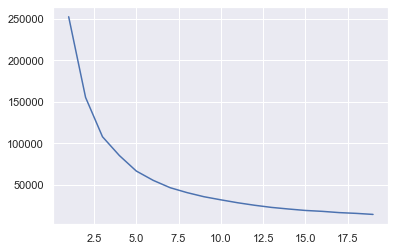

In [204]:
from sklearn.cluster import KMeans

# Trouve le coude pour connaître le nombre de clusters optimal
inertia = []
K_range = range(1, 20)

for K in K_range:
    model = KMeans(n_clusters = K).fit(X)
    inertia.append(model.inertia_)
plt.plot(K_range, inertia)

# 3 HERE

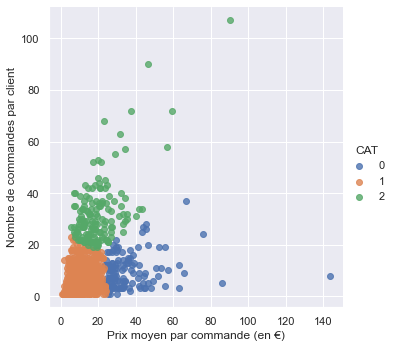

In [203]:
from sklearn.cluster import KMeans

X = df_command
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df_command["CAT"] = kmeans.labels_

ax = sns.lmplot(x = "MEAN", y =  "COUNT", data = df_command, fit_reg = False, hue = "CAT")

ax.set(
    xlabel = "Prix moyen par commande (en €)",
    ylabel = "Nombre de commandes par client"
)

In [225]:
# A partir de ces clusters on peut appliquer le model préalablement défini aux echantillons de chaques cluster.
# De fait, la prédiction sera plus proche du profil de l'utilisateur puisque basée sur des critères identiques à l'utilisateur
CLI_ID = 1490281

# Récupère les elements dont la catégorie est identique à l'user indiqué (CLI_ID = 1490281)
df_prix = df_command.loc[(df_command.CAT == df_command.loc[int(CLI_ID)].CAT)]
display(df.loc[(df.CLI_ID.isin(df_prix.index))])

# A partir de là, le dataframe est identique à celui utilisé pour le model (3904 entrées au lieu des 10 000 ici)
# Il faut re-implémenter dans le model défini plus haut ce nouveau dataframe (à voir dans le rendu de l'app streamlit)

,TICKET_ID,MOIS_VENTE,PRIX_NET,FAMILLE,UNIVERS,MAILLE,LIBELLE,CLI_ID
0,35592159,10,1.67,HYGIENE,HYG_DOUCHE JARDINMONDE,HYG_JDM,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281
1,35592159,10,1.66,HYGIENE,HYG_DOUCHE JARDINMONDE,HYG_JDM,GD JDM4 PAMPLEMOUSSE FL 200ML,1490281
2,35592159,10,7.45,SOINS DU VISAGE,VIS_CJOUR Jeunes Specifique,VIS_JEUNE_ET_LEVRE,CR JR PARF BIO.SPE AC.SENT.50ML,1490281
3,35592159,10,5.95,SOINS DU VISAGE,VIS_DEMAQ AAAR,VIS_AAAR_DEMAQLOTION,EAU MICELLAIRE 3 THES FL200ML,1490281
4,35592159,10,1.67,HYGIENE,HYG_DOUCHE JARDINMONDE,HYG_JDM,GD JDM4 TIARE FL 200ML,1490281
...,...,...,...,...,...,...,...,...
9995,33934312,4,6.95,HYGIENE,HYG_DEO PARFUMS,HYG_PARFUMEE,DEO PARFUME 100ML EVIDENCE,903871816
9996,33988514,4,4.75,MAQUILLAGE,MAQ_YEUX Sourcils,MAQ_YEUX_CLASSIQUE,CRAYON SOURCILS CHATAIN CN3 1.1G,903871816
9997,33988514,4,7.90,MAQUILLAGE,MAQ_YEUX Crayons,MAQ_YEUX_CLASSIQUE,CRAYON REGARD NOIR CN3 1.3G,903871816
9998,34302529,6,13.90,HYGIENE,HYG_DEO PARFUMS,HYG_PARFUMEE,DEO PARFUME 100ML EVIDENCE,903871816
